## Dataset Overview

### 1. `equipment1.csv`
- This file contains sensor data from Equipment 1 during the wafer manufacturing process.
- Each row corresponds to one timestamp for a specific wafer.

### 2. `equipment2.csv`
- Same structure as `equipment1.csv`, but the data comes from Equipment 2.
- The value ranges can be different because this is a different machine.

### 3. `response.csv`
- This file contains the target labels (ground truth) for each wafer.
- Each row is one wafer.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)

base_path = "EquipmentDataFinal"

eq1 = pd.read_csv(f"{base_path}/equipment1.csv", sep=";")
eq2 = pd.read_csv(f"{base_path}/equipment2.csv", sep=";")
resp = pd.read_csv(f"{base_path}/response.csv", sep=";")

print("equipment1:", eq1.shape)
print("equipment2:", eq2.shape)
print("response:", resp.shape)

eq1.head()

equipment1: (170896, 27)
equipment2: (232144, 35)
response: (2638, 4)


,lot,wafer,timestamp,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24
0,lot2,1,timestamp_0,0.0,0.0,15.1604,105.4170,99.18,0.0,2.77728,...,0.0,0.0,7.0,200.0,151.891,0.0,47.5,0.0,-1.0,19.05
1,lot2,1,timestamp_1,0.0,0.0,15.0920,100.5100,98.18,0.0,2.77465,...,0.0,0.0,7.0,200.0,151.402,0.0,48.5,0.0,-1.0,0.99
2,lot2,1,timestamp_2,0.0,0.0,15.0432,95.3093,95.18,0.0,2.86352,...,0.0,0.0,7.0,200.0,149.815,0.0,48.0,0.0,-1.0,0.99
3,lot2,1,timestamp_3,0.0,0.0,15.0334,94.7234,93.18,0.0,3.27855,...,0.0,0.0,7.0,200.0,150.182,0.0,48.0,0.0,-1.0,1.10
4,lot2,1,timestamp_4,0.0,0.0,15.0432,91.9401,91.18,0.0,3.48645,...,0.0,0.0,7.0,200.0,150.182,0.0,47.5,0.0,-1.0,0.89


- Main columns:
  - `lot`: production lot ID (wafer batch)
  - `wafer`: wafer ID/number
  - `timestamp`: time step index (time-series)
  - `sensor_1` ~ `sensor_24`: sensor readings (e.g., temperature, pressure, vibration, etc.)
- So, for each (lot, wafer, timestamp) combination, we have 24 sensor values.
- The number of rows is very large (around 170000), which is normal for time-series process data.

In [7]:
eq2.head()

,lot,wafer,timestamp,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,...,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56
0,lot2,1,timestamp_0,0.0,382.64,99.0,11.0,0.0,0.0,0.305503,...,2177.084,0.0,1.0,-0.1,1.8,199.7436,724.5978,0.000009,1.302417,1.00
1,lot2,1,timestamp_1,0.0,382.64,99.0,11.0,0.0,0.0,0.304918,...,2177.084,0.0,1.0,-0.1,1.8,199.6521,724.5978,0.000008,1.304668,1.18
2,lot2,1,timestamp_2,0.0,382.64,99.0,11.0,0.0,0.0,0.307562,...,2177.084,0.0,1.0,-0.1,1.8,199.7436,724.5978,0.000008,1.302417,0.93
3,lot2,1,timestamp_3,0.0,382.64,99.0,11.0,0.0,0.0,0.306975,...,2177.084,0.0,1.0,-0.1,1.8,199.7131,724.5978,0.000008,1.302417,0.94
4,lot2,1,timestamp_4,0.0,382.64,99.0,11.0,0.0,0.0,0.305274,...,2177.084,0.0,1.0,-0.1,1.8,199.7742,724.5978,0.000008,1.302417,1.03


- Columns are the same:
  - `lot`, `wafer`, `timestamp`, `sensor_1` ~ `sensor_24`
- For many wafers, we can think of this as a “parallel” time-series from another piece of equipment.
- Later, we can combine (merge) Equipment 1 + 2 sensor data to build a richer feature set.

In [9]:
resp.head()

,lot,wafer,response,class
0,lot2,1,1.0278,bad
1,lot2,2,0.3906,good
2,lot2,3,0.3906,good
3,lot2,4,0.4050,good
4,lot2,5,0.4050,good


- Main columns:
  - `lot`: production lot ID
  - `wafer`: wafer ID/number
  - `response`: continuous quality score (numeric)
  - `class`: categorical quality label (e.g., good / bad)
- Unlike the sensor files (time-series), this file has one label per wafer.
- In supervised learning, I will:
  - aggregate the time-series sensor data into wafer-level features, and  
  - use response / class as the target variables.

## Equipment1 EDA

In [14]:
eq1.head()

,lot,wafer,timestamp,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24
0,lot2,1,timestamp_0,0.0,0.0,15.1604,105.4170,99.18,0.0,2.77728,...,0.0,0.0,7.0,200.0,151.891,0.0,47.5,0.0,-1.0,19.05
1,lot2,1,timestamp_1,0.0,0.0,15.0920,100.5100,98.18,0.0,2.77465,...,0.0,0.0,7.0,200.0,151.402,0.0,48.5,0.0,-1.0,0.99
2,lot2,1,timestamp_2,0.0,0.0,15.0432,95.3093,95.18,0.0,2.86352,...,0.0,0.0,7.0,200.0,149.815,0.0,48.0,0.0,-1.0,0.99
3,lot2,1,timestamp_3,0.0,0.0,15.0334,94.7234,93.18,0.0,3.27855,...,0.0,0.0,7.0,200.0,150.182,0.0,48.0,0.0,-1.0,1.10
4,lot2,1,timestamp_4,0.0,0.0,15.0432,91.9401,91.18,0.0,3.48645,...,0.0,0.0,7.0,200.0,150.182,0.0,47.5,0.0,-1.0,0.89


In [15]:
# Print all column names
print("Columns in equipment1:")
print(list(eq1.columns))

# Data types
print("\nData types:")
print(eq1.dtypes)

Columns in equipment1:
['lot', 'wafer', 'timestamp', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24']

Data types:
lot           object
wafer          int64
timestamp     object
sensor_1     float64
sensor_2     float64
sensor_3     float64
sensor_4     float64
sensor_5     float64
sensor_6     float64
sensor_7     float64
sensor_8     float64
sensor_9     float64
sensor_10    float64
sensor_11    float64
sensor_12    float64
sensor_13    float64
sensor_14    float64
sensor_15    float64
sensor_16    float64
sensor_17    float64
sensor_18    float64
sensor_19    float64
sensor_20    float64
sensor_21    float64
sensor_22    float64
sensor_23    float64
sensor_24    float64
dtype: object


In [16]:
# Identify which columns are sensors
sensor_cols_eq1 = [c for c in eq1.columns if c.startswith("sensor_")]
print("Number of sensors:", len(sensor_cols_eq1))
print("Sensor columns example:", sensor_cols_eq1[:10])

Number of sensors: 24
Sensor columns example: ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10']


In [17]:
# Summary statistics
eq1[sensor_cols_eq1].describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
sensor_1,170896.0,4.067866,9.150628,-0.063558,0.000000e+00,0.000000,0.00000,29.9625
sensor_2,170896.0,4.121005,9.211179,0.000000,0.000000e+00,0.000000,0.00000,30.0000
sensor_3,170896.0,37.679053,50.805718,-1.672790,1.457320e+01,15.033400,74.99470,153.0710
sensor_4,170896.0,32.396468,34.610954,0.000000,0.000000e+00,24.999900,84.32260,136.5550
sensor_5,170896.0,32.348691,34.747412,0.000000,0.000000e+00,25.000000,85.00000,100.0000
sensor_6,170896.0,0.137369,7.639594,0.000000,0.000000e+00,0.000000,0.00000,507.5980
sensor_7,170896.0,10.663262,13.011113,0.000000,3.339950e+00,4.261595,12.93625,100.4430
sensor_8,170896.0,0.962059,1.909727,0.000000,8.150137e-17,0.488296,1.00711,19.8370
sensor_9,170896.0,7.350330,5.011755,0.000000,2.000000e+00,9.000000,12.00000,14.0000
sensor_10,170896.0,11.727677,11.534396,0.000000,2.040000e+00,7.550000,18.89000,40.0000


In [18]:
# Overall missing percentage per column
missing_ratio = eq1.isna().mean().sort_values(ascending=False)
missing_ratio.head(15)

lot          0.0
sensor_12    0.0
sensor_23    0.0
sensor_22    0.0
sensor_21    0.0
sensor_20    0.0
sensor_19    0.0
sensor_18    0.0
sensor_17    0.0
sensor_16    0.0
sensor_15    0.0
sensor_14    0.0
sensor_13    0.0
sensor_11    0.0
wafer        0.0
dtype: float64

In [19]:
# Missing ratio for sensors only
sensor_missing = eq1[sensor_cols_eq1].isna().mean().sort_values(ascending=False)
sensor_missing.head(20)

sensor_1     0.0
sensor_2     0.0
sensor_23    0.0
sensor_22    0.0
sensor_21    0.0
sensor_20    0.0
sensor_19    0.0
sensor_18    0.0
sensor_17    0.0
sensor_16    0.0
sensor_15    0.0
sensor_14    0.0
sensor_13    0.0
sensor_12    0.0
sensor_11    0.0
sensor_10    0.0
sensor_9     0.0
sensor_8     0.0
sensor_7     0.0
sensor_6     0.0
dtype: float64

No Missing Value

In [21]:
# Wafer/timestamp structure analysis

# Unique (lot, wafer) combinations
unique_wafers = eq1[["lot", "wafer"]].drop_duplicates()
print("Unique wafers in equipment1:", unique_wafers.shape[0])

Unique wafers in equipment1: 971


In [22]:
# How many timestamps each wafer has
ts_count = eq1.groupby(["lot", "wafer"])["timestamp"].nunique()
ts_count.describe()

count    971.0
mean     176.0
std        0.0
min      176.0
25%      176.0
50%      176.0
75%      176.0
max      176.0
Name: timestamp, dtype: float64

All the timestamp has 176 timestamps

In [24]:
# Select one wafer to analyze
sample_lot, sample_wafer = unique_wafers.iloc[0]
print("Selected wafer:", sample_lot, sample_wafer)

Selected wafer: lot2 1


In [26]:
# Extract time-series data for lot2
sample_df = eq1[(eq1["lot"] == sample_lot) & (eq1["wafer"] == sample_wafer)]
sample_df = sample_df.sort_values("timestamp")

sample_df.head()

,lot,wafer,timestamp,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24
0,lot2,1,timestamp_0,0.0,0.0,15.1604,105.4170,99.18,0.0,2.77728,...,0.0,0.0,7.0,200.000,151.891,0.0,47.5,0.0,-1.0,19.05
1,lot2,1,timestamp_1,0.0,0.0,15.0920,100.5100,98.18,0.0,2.77465,...,0.0,0.0,7.0,200.000,151.402,0.0,48.5,0.0,-1.0,0.99
10,lot2,1,timestamp_10,0.0,0.0,15.0334,84.4691,85.00,0.0,3.26765,...,0.0,0.0,7.0,200.000,148.228,0.0,47.5,0.0,-1.0,0.95
100,lot2,1,timestamp_100,0.0,0.0,15.0432,0.0000,0.00,0.0,2.59184,...,0.0,0.0,7.0,610.892,148.228,32.0,47.0,0.0,-1.0,0.94
101,lot2,1,timestamp_101,0.0,0.0,15.0334,0.0000,0.00,0.0,3.55585,...,0.0,0.0,7.0,595.192,147.862,26.0,48.5,0.0,-1.0,1.05


Example sensor: sensor_1


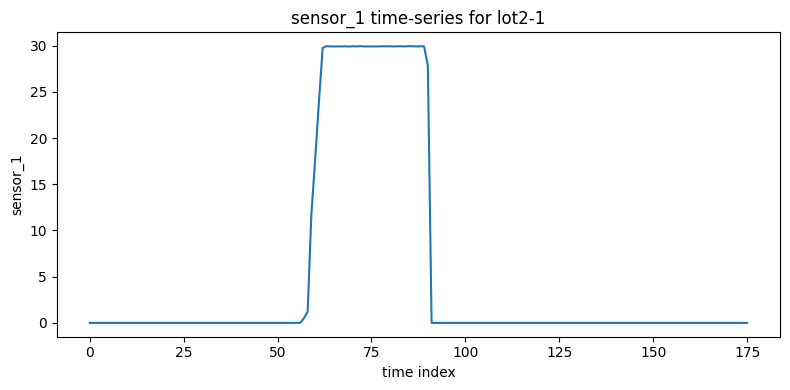

In [ ]:
example_sensor = sensor_cols_eq1[0]
print("Example sensor:", example_sensor)

sample_df = eq1[(eq1["lot"] == sample_lot) & (eq1["wafer"] == sample_wafer)].copy()
sample_df["ts_num"] = sample_df["timestamp"].str.replace("timestamp_", "").astype(int)

sample_df = sample_df.sort_values("ts_num").reset_index(drop=True)

plt.plot(sample_df["ts_num"], sample_df[example_sensor])
plt.xlabel("time index")
plt.ylabel(example_sensor)
plt.title(f"{example_sensor} time-series for {sample_lot}-{sample_wafer}")
plt.tight_layout()
plt.show()


#### Sensor time-series example (sensor_1 for lot2-1)

The time-series plot of sensor_1 shows a very clear pattern -> the signal stays flat at 0 for a long period, suddenly increases to around 30, remains stable for a few time steps, and then drops back to 0. This suggests that the sensor is not “dead,” but instead its normal behavior includes long periods of inactivity followed by a short process step where values spike.

This is a common pattern in semiconductor equipment data where only a specific part of the recipe triggers sensor activity.
The sensor is therefore not missing or malfunctioning. It simply has a sparse activation window.

In [28]:
# Correlation between sensors
sample_sensors = sensor_cols_eq1[:10]
corr = eq1[sample_sensors].corr()
corr

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
sensor_1,1.000000,0.993280,-0.239192,-0.355976,-0.353972,-0.007993,0.624131,-0.076127,0.198269,-0.153651
sensor_2,0.993280,1.000000,-0.241172,-0.357392,-0.355604,-0.008045,0.625090,-0.075053,0.196938,-0.155697
sensor_3,-0.239192,-0.241172,1.000000,-0.063801,-0.062968,0.004592,-0.265600,0.099909,0.295742,0.286596
sensor_4,-0.355976,-0.357392,-0.063801,1.000000,0.986397,-0.006752,-0.321273,0.242838,0.013430,0.447082
sensor_5,-0.353972,-0.355604,-0.062968,0.986397,1.000000,-0.001769,-0.330334,0.241065,0.021159,0.447706
sensor_6,-0.007993,-0.008045,0.004592,-0.006752,-0.001769,1.000000,-0.009478,-0.006121,-0.026372,-0.017212
sensor_7,0.624131,0.625090,-0.265600,-0.321273,-0.330334,-0.009478,1.000000,-0.107302,0.161335,-0.233273
sensor_8,-0.076127,-0.075053,0.099909,0.242838,0.241065,-0.006121,-0.107302,1.000000,-0.093187,0.048354
sensor_9,0.198269,0.196938,0.295742,0.013430,0.021159,-0.026372,0.161335,-0.093187,1.000000,0.154561
sensor_10,-0.153651,-0.155697,0.286596,0.447082,0.447706,-0.017212,-0.233273,0.048354,0.154561,1.000000


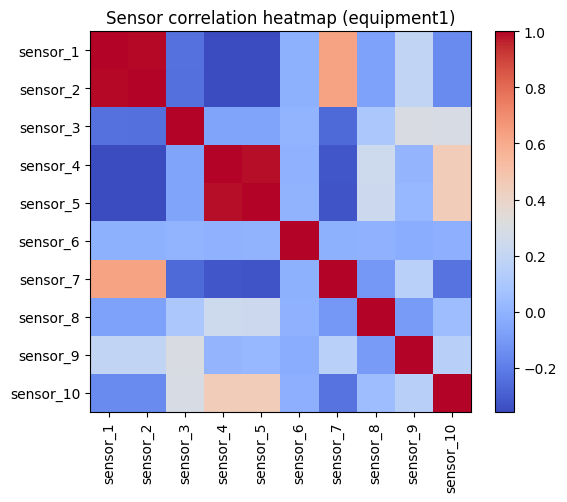

In [29]:
fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(corr.values, interpolation="nearest", cmap="coolwarm")
ax.set_xticks(range(len(sample_sensors)))
ax.set_yticks(range(len(sample_sensors)))
ax.set_xticklabels(sample_sensors, rotation=90)
ax.set_yticklabels(sample_sensors)
fig.colorbar(cax)
plt.title("Sensor correlation heatmap (equipment1)")
plt.tight_layout()
plt.show()

1. sensor_1 and sensor_2 are almost perfectly correlated (corr ≈ 0.99).
→ These two sensors probably measure nearly the same physical quantity or one is derived from the other.

2. Some sensor pairs show moderate correlations (positive or negative), meaning the underlying physical processes are not independent.

3. Several sensors show correlations close to zero, indicating that they are measuring unrelated parts of the process.

This suggests that dimensionality reduction or feature selection may be needed later, because some sensors appear redundant while others provide unique information.

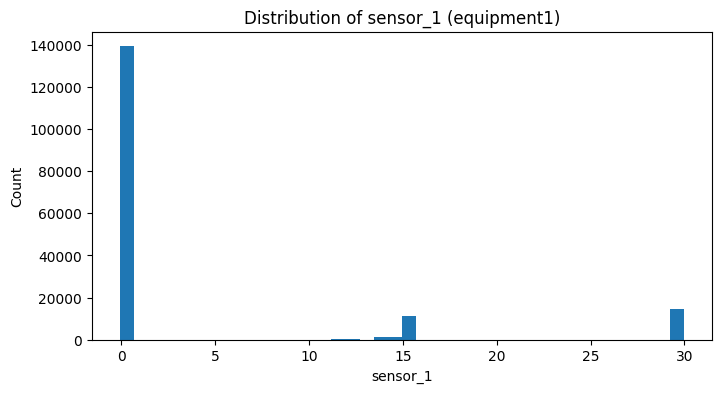

In [30]:
plt.hist(eq1[example_sensor].dropna(), bins=40)
plt.xlabel(example_sensor)
plt.ylabel("Count")
plt.title(f"Distribution of {example_sensor} (equipment1)")
plt.show()

This matches what we saw in the time-series: sensor_1 is mostly inactive. This distribution confirms that the sensor has very low variance during most of the recipe and only activates during specific phases. This is not noise—it's a characteristic of the process.

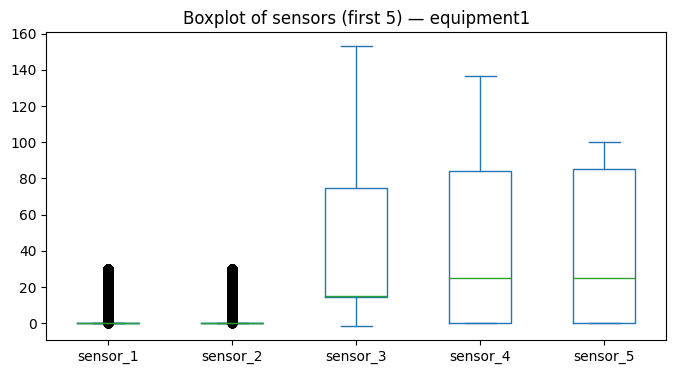

In [31]:
eq1[sensor_cols_eq1[:5]].plot(kind="box")
plt.title("Boxplot of sensors (first 5) — equipment1")
plt.show()

sensor_1 and sensor_2
→ Values mostly sit at 0, with rare large spikes.
→ Extremely skewed with many outliers.

sensor_3, sensor_4, and sensor_5
→ Much wider range and smoother distribution.
→ These sensors are active throughout the process.

This means that some sensors (like 1 and 2) act as "event detectors," while others provide continuous measurements. Later on, these differences will be important for modeling because sparse sensors may require special treatment (e.g., normalization, clipping) and continuous sensors may carry most of the predictive power.

In [40]:
# Constant sensors

# Variance of each sensor
sensor_variances = eq1[sensor_cols_eq1].var()
sensor_variances_sorted = sensor_variances.sort_values()

print("Smallest variances (potential near-constant sensors):")
print(sensor_variances_sorted.head(10))

near_constant_threshold = 1e-3
near_constant_sensors = sensor_variances_sorted[sensor_variances_sorted < near_constant_threshold]
print("\nSensors with variance < threshold:")
print(near_constant_sensors)


Smallest variances (potential near-constant sensors):
sensor_14     0.189593
sensor_13     0.189593
sensor_15     0.189713
sensor_16     0.189720
sensor_24     1.567654
sensor_8      3.647059
sensor_17     4.886604
sensor_9     25.117691
sensor_6     58.363400
sensor_1     83.733988
dtype: float64

Sensors with variance < threshold:
Series([], dtype: float64)


Computed the variance of all 24 sensors and sorted them from smallest to largest.

Findings: 
1. None of the sensors have near-zero variance (threshold = 1e-3).
→ This means no sensor is completely constant, and all of them show at least some activity.

2. However, sensors like sensor_14, sensor_13, sensor_15, sensor_16 have relatively low variance compared to the others.
→ These might still carry limited information because they do not change much during the process.

Sensors with extremely small variance usually do not help machine learning models.
In our dataset, we do not have purely “dead constant” sensors, but a few sensors show low variation and may be less informative.

In [41]:
# Number of unique values per sensor
sensor_unique_counts = eq1[sensor_cols_eq1].nunique().sort_values()

print("\nSensors with the fewest unique values:")
print(sensor_unique_counts.head(10))


Sensors with the fewest unique values:
sensor_17      5
sensor_23      7
sensor_9      15
sensor_11     44
sensor_6      60
sensor_12     63
sensor_20     63
sensor_16    200
sensor_15    201
sensor_14    201
dtype: int64


Counted how many unique values each sensor has.

Findings:
1. sensor_17 has only 5 unique values
2. sensor_23 has 7 unique values

Sensors with few unique values can behave like digital ON/OFF signals. These might still be useful, but they generally contain less information than continuous sensors. We should consider grouping them as "discrete sensors" later.

Sensors with the highest zero ratio:
sensor_6     0.999655
sensor_12    0.999614
sensor_1     0.812324
sensor_2     0.811669
sensor_16    0.696827
sensor_15    0.696827
sensor_14    0.696827
sensor_13    0.696827
sensor_22    0.696769
sensor_20    0.654059
dtype: float64


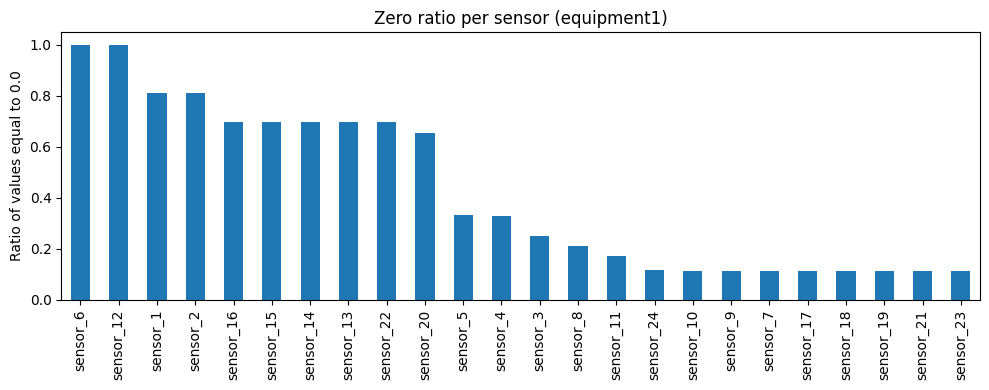

In [36]:
# Zero-heavy sensors -> potential dead sensors
# Ratio of zeros in each sensor
zero_ratio = (eq1[sensor_cols_eq1] == 0).mean().sort_values(ascending=False)

print("Sensors with the highest zero ratio:")
print(zero_ratio.head(10))

# zero ratio for all sensors
plt.figure(figsize=(10, 4))
zero_ratio.plot(kind="bar")
plt.title("Zero ratio per sensor (equipment1)")
plt.ylabel("Ratio of values equal to 0.0")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

1. sensor_6 and sensor_12 are almost always zero → likely “dead” or inactive sensors.
2. sensor_1, sensor_2, sensor_15, sensor_16 are zero-heavy, meaning they only activate briefly during the process. -> These may represent ON/OFF type operational switches rather than continuous process signals.

These sensors should be handled carefully — they may not contribute much to prediction unless the rare non-zero activation is meaningful.

In [37]:
# Duplicate (lot, wafer, timestamp) checks

# Check for duplicated (lot, wafer, timestamp) combinations
dup_mask = eq1.duplicated(subset=["lot", "wafer", "timestamp"], keep=False)
num_duplicates = dup_mask.sum()

print("Number of rows with duplicated (lot, wafer, timestamp):", num_duplicates)

# Inspect few duplicates if they exist
if num_duplicates > 0:
    dup_examples = eq1[dup_mask].sort_values(["lot", "wafer", "timestamp"]).head(20)
    display(dup_examples)
else:
    print("No duplicated (lot, wafer, timestamp) combinations found in equipment1.")

Number of rows with duplicated (lot, wafer, timestamp): 0
No duplicated (lot, wafer, timestamp) combinations found in equipment1.


0 duplicated rows found -> The time-series structure is completely clean. Each wafer has exactly one record per timestamp, which makes downstream feature extraction much easier.

Outlier counts per sensor (|z| > 3):
sensor_8     3703
sensor_7     1053
sensor_11     814
sensor_24     526
sensor_12      66
sensor_6       59
sensor_19       2
sensor_4        1
sensor_16       0
sensor_23       0
dtype: int64

Sensor with most outliers: sensor_8


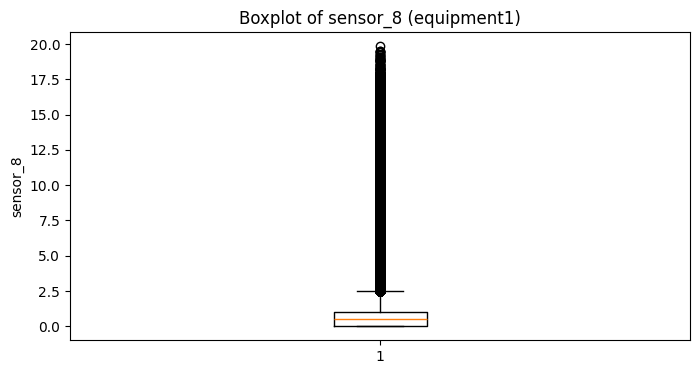

In [38]:
# Simple outlier screening per sensor

from scipy import stats

# z-score based outlier count per sensor (|z| > 3)
outlier_counts = {}

for col in sensor_cols_eq1:
    vals = eq1[col].dropna()
    if vals.std() == 0:
        outlier_counts[col] = 0
        continue
    z = np.abs((vals - vals.mean()) / vals.std())
    outlier_counts[col] = (z > 3).sum()

outlier_counts = pd.Series(outlier_counts).sort_values(ascending=False)

print("Outlier counts per sensor (|z| > 3):")
print(outlier_counts.head(10))

# sensor with the most outliers
sensor_most_outliers = outlier_counts.index[0]
print("\nSensor with most outliers:", sensor_most_outliers)

vals = eq1[sensor_most_outliers].dropna()

plt.boxplot(vals)
plt.title(f"Boxplot of {sensor_most_outliers} (equipment1)")
plt.ylabel(sensor_most_outliers)
plt.show()


Computed |z| > 3 for each sensor to detect extreme values.

Sensor_8 stands out as having a large number of extreme readings. This might indicate true abnormal process behavior / sensor noise or instability.

Most other sensors have few or no outliers, meaning they are stable.

Outliers may be useful for detecting defective wafers, so removing them blindly is not recommended.

### Final interpretation of equipment 1 EDA

Based on my exploratory data analysis of Equipment 1, the dataset appears clean and well-structured. There are no missing values, and every wafer has exactly 176 timestamps, which means the time-series is complete and consistent across all samples. This is helpful because I can extract features without worrying about interpolation or broken sequences.

The sensors themselves show mixed behavior. Some sensors, such as sensor_1 and sensor_2 stay at zero for most of the process and only activate briefly. This does not indicate malfunction, it simply means these senssors monitor specific steps that occur only once during the recipe. A few sensors, like sensor_6 and sensor_12, are almost always zero, so they may be in active or rarely triggered. In contrast, sensors like sensor_3 and sensor_5 have smooth, continuous patterns and likely capture the main physical variables.

The correlation and variance analysis also shows that several sensors are redundant (sensor 1 and sensor 2 are almost identical), while others have low variation or very few unique values. These characteristics suggest that later on, feature selection or dimensionality reduction will be useful to avoid giving the model unnecessary inputs. Outlier detection further shows that most sensors are stable, except sensor_8, which has many extreme values and might capture meaningful process fluctuations.

Overall, Equipment 1 data is clean but heterogeneous -> it contains continuous sensors, sparse event-type sensors, and some nearly inactive ones. These differences will matter when building wafer-level features and choosing which signals are most important for predicting the final wafer quality.

## Equipment2 EDA

In [42]:
eq2.head()

,lot,wafer,timestamp,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,...,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52,sensor_53,sensor_54,sensor_55,sensor_56
0,lot2,1,timestamp_0,0.0,382.64,99.0,11.0,0.0,0.0,0.305503,...,2177.084,0.0,1.0,-0.1,1.8,199.7436,724.5978,0.000009,1.302417,1.00
1,lot2,1,timestamp_1,0.0,382.64,99.0,11.0,0.0,0.0,0.304918,...,2177.084,0.0,1.0,-0.1,1.8,199.6521,724.5978,0.000008,1.304668,1.18
2,lot2,1,timestamp_2,0.0,382.64,99.0,11.0,0.0,0.0,0.307562,...,2177.084,0.0,1.0,-0.1,1.8,199.7436,724.5978,0.000008,1.302417,0.93
3,lot2,1,timestamp_3,0.0,382.64,99.0,11.0,0.0,0.0,0.306975,...,2177.084,0.0,1.0,-0.1,1.8,199.7131,724.5978,0.000008,1.302417,0.94
4,lot2,1,timestamp_4,0.0,382.64,99.0,11.0,0.0,0.0,0.305274,...,2177.084,0.0,1.0,-0.1,1.8,199.7742,724.5978,0.000008,1.302417,1.03


In [43]:
print("Columns in equipment2:")
print(list(eq2.columns))

print("\nData types:")
print(eq2.dtypes)

Columns in equipment2:
['lot', 'wafer', 'timestamp', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50', 'sensor_51', 'sensor_52', 'sensor_53', 'sensor_54', 'sensor_55', 'sensor_56']

Data types:
lot           object
wafer          int64
timestamp     object
sensor_25    float64
sensor_26    float64
sensor_27    float64
sensor_28    float64
sensor_29    float64
sensor_30    float64
sensor_31    float64
sensor_32    float64
sensor_33    float64
sensor_34    float64
sensor_35    float64
sensor_36    float64
sensor_37    float64
sensor_38    float64
sensor_39    float64
sensor_40    float64
sensor_41    float64
sensor_42    float64
sensor_43    float64
sensor_44    float64
sensor_45    float64
sensor_46    f

In [44]:
# Identify which columns are sensors
sensor_cols_eq2 = [c for c in eq2.columns if c.startswith("sensor_")]
print("\nNumber of sensors in equipment2:", len(sensor_cols_eq2))
print("Example sensor columns:", sensor_cols_eq2[:10])

eq2[sensor_cols_eq2].describe().T.head(10)


Number of sensors in equipment2: 32
Example sensor columns: ['sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34']


,count,mean,std,min,25%,50%,75%,max
sensor_25,232144.0,0.001403,0.001864,0.0,0.0,0.000000e+00,0.004064,0.004980
sensor_26,232144.0,154.539367,156.651277,0.0,0.0,1.020960e+02,278.119450,488.345900
sensor_27,232144.0,61.388629,48.269289,0.0,0.0,9.900000e+01,99.000000,100.000000
sensor_28,232144.0,7.010709,5.525500,0.0,0.0,1.100000e+01,11.000000,13.000000
sensor_29,232144.0,0.001700,0.003756,0.0,0.0,0.000000e+00,0.000000,0.010000
sensor_30,232144.0,20.873311,24.637101,0.0,0.0,0.000000e+00,49.980000,49.990000
sensor_31,232144.0,10.445576,13.512858,0.0,0.0,2.782606e-02,19.997920,65.291170
sensor_32,232144.0,75.038648,110.904908,0.0,0.0,6.160617e-01,239.976800,241.599300
sensor_33,232144.0,0.000202,0.014227,0.0,0.0,0.000000e+00,0.000000,1.000000
sensor_34,232144.0,0.001861,0.002045,0.0,0.0,8.239451e-07,0.004125,0.004125


In [46]:
# Missing values
# Overall missing percentage per column
missing_ratio_eq2 = eq2.isna().mean().sort_values(ascending=False)
print("Top columns by missing ratio (equipment2):")
print(missing_ratio_eq2.head(15))

# Missing ratio for sensors
sensor_missing_eq2 = eq2[sensor_cols_eq2].isna().mean().sort_values(ascending=False)
print("\nMissing ratio for sensors only (equipment2):")
print(sensor_missing_eq2.head(20))

Top columns by missing ratio (equipment2):
lot          0.0
sensor_48    0.0
sensor_42    0.0
sensor_43    0.0
sensor_44    0.0
sensor_45    0.0
sensor_46    0.0
sensor_47    0.0
sensor_49    0.0
sensor_40    0.0
sensor_50    0.0
sensor_51    0.0
sensor_52    0.0
sensor_53    0.0
sensor_54    0.0
dtype: float64

Missing ratio for sensors only (equipment2):
sensor_25    0.0
sensor_26    0.0
sensor_55    0.0
sensor_54    0.0
sensor_53    0.0
sensor_52    0.0
sensor_51    0.0
sensor_50    0.0
sensor_49    0.0
sensor_48    0.0
sensor_47    0.0
sensor_46    0.0
sensor_45    0.0
sensor_44    0.0
sensor_43    0.0
sensor_42    0.0
sensor_41    0.0
sensor_40    0.0
sensor_39    0.0
sensor_38    0.0
dtype: float64


No missing values

Unique wafers in equipment2: 1319
count    1319.0
mean      176.0
std         0.0
min       176.0
25%       176.0
50%       176.0
75%       176.0
max       176.0
Name: timestamp, dtype: float64


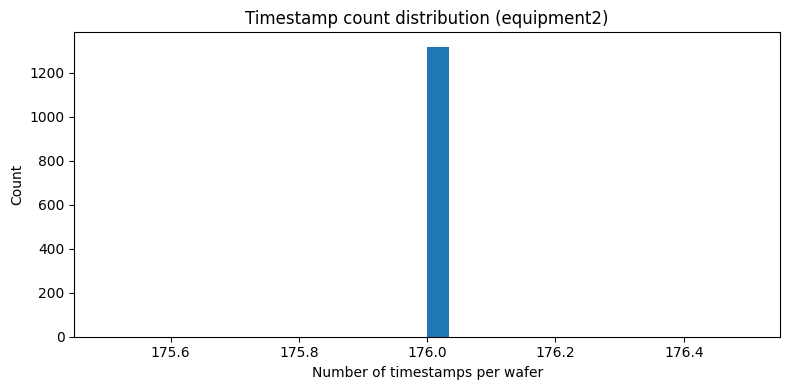

In [47]:
# Wafer / timestamp structure
# Unique (lot, wafer) combinations
unique_wafers_eq2 = eq2[["lot", "wafer"]].drop_duplicates()
print("Unique wafers in equipment2:", unique_wafers_eq2.shape[0])

# How many timestamps each wafer has
ts_count_eq2 = eq2.groupby(["lot", "wafer"])["timestamp"].nunique()
print(ts_count_eq2.describe())

plt.hist(ts_count_eq2, bins=30)
plt.xlabel("Number of timestamps per wafer")
plt.ylabel("Count")
plt.title("Timestamp count distribution (equipment2)")
plt.tight_layout()
plt.show()

Same as equipment 1, everything has 176 timestamps.

Selected wafer for equipment2: lot2 1
Example sensor (equipment2): sensor_25


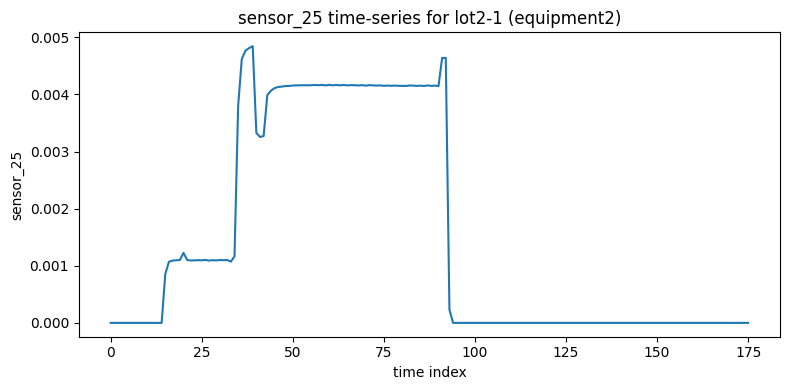

In [49]:
# Example time-series for one wafer 
sample_lot2, sample_wafer2 = unique_wafers_eq2.iloc[0]
print("Selected wafer for equipment2:", sample_lot2, sample_wafer2)

# Extract time-series data for that wafer
sample_df2 = eq2[(eq2["lot"] == sample_lot2) & (eq2["wafer"] == sample_wafer2)].copy()

# Convert "timestamp_xx" -> integer index
sample_df2["ts_num"] = sample_df2["timestamp"].str.replace("timestamp_", "").astype(int)

# Sort by time index and reset row index
sample_df2 = sample_df2.sort_values("ts_num").reset_index(drop=True)

example_sensor2 = sensor_cols_eq2[0]
print("Example sensor (equipment2):", example_sensor2)

plt.plot(sample_df2["ts_num"], sample_df2[example_sensor2])
plt.xlabel("time index")
plt.ylabel(example_sensor2)
plt.title(f"{example_sensor2} time-series for {sample_lot2}-{sample_wafer2} (equipment2)")
plt.tight_layout()
plt.show()


1. sensor_25 shows a clear pattern: long periods at zero, followed by a sharp rise, a stable plateau, and then a return to zero. -> This indicates a step-triggered sensor that activates only during a specific part of the manufacturing recipe.
2. It is not a broken or dead sensor — its sparse activity is part of the normal process. -> This behavior is similar to the sparse-activation sensors observed in Equipment1 (e.g., sensor_1, sensor_2).

In [50]:
# Correlation between sensors
sample_sensors_eq2 = sensor_cols_eq2[:10]

corr_eq2 = eq2[sample_sensors_eq2].corr()
corr_eq2

,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34
sensor_25,1.000000,0.465194,0.591837,0.589123,0.212012,0.880743,0.610200,0.975565,0.016913,0.833080
sensor_26,0.465194,1.000000,0.774689,0.782165,0.269251,0.523007,0.476726,0.419212,0.018457,0.561428
sensor_27,0.591837,0.774689,1.000000,0.997648,0.357014,0.666189,0.607810,0.532030,0.011088,0.715619
sensor_28,0.589123,0.782165,0.997648,1.000000,0.364753,0.661920,0.601945,0.530040,0.012849,0.712109
sensor_29,0.212012,0.269251,0.357014,0.364753,1.000000,0.237325,0.213916,0.192760,0.004844,0.255451
sensor_30,0.880743,0.523007,0.666189,0.661920,0.237325,1.000000,0.851366,0.795987,0.014355,0.937746
sensor_31,0.610200,0.476726,0.607810,0.601945,0.213916,0.851366,1.000000,0.477729,0.007373,0.853129
sensor_32,0.975565,0.419212,0.532030,0.530040,0.192760,0.795987,0.477729,1.000000,0.017234,0.746460
sensor_33,0.016913,0.018457,0.011088,0.012849,0.004844,0.014355,0.007373,0.017234,1.000000,0.015751
sensor_34,0.833080,0.561428,0.715619,0.712109,0.255451,0.937746,0.853129,0.746460,0.015751,1.000000


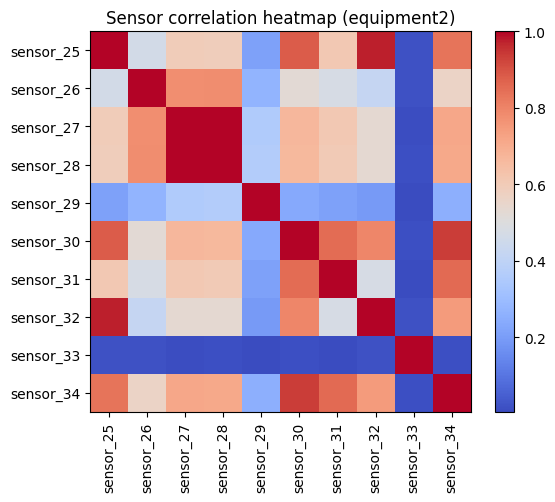

In [51]:
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(corr_eq2.values, interpolation="nearest", cmap="coolwarm")
ax.set_xticks(range(len(sample_sensors_eq2)))
ax.set_yticks(range(len(sample_sensors_eq2)))
ax.set_xticklabels(sample_sensors_eq2, rotation=90)
ax.set_yticklabels(sample_sensors_eq2)
fig.colorbar(cax)
plt.title("Sensor correlation heatmap (equipment2)")
plt.tight_layout()
plt.show()

sensor_30 and sensor_34 show extremely high correlation (≈ 0.94), suggesting they measure nearly the same physical quantity or one is derived from the other.

Several sensors have moderate correlations, indicating partial coupling in the underlying process.

Some sensors, such as sensor_25 and sensor_33, have very low correlation with others, meaning they capture unique information.

Overall, Equipment2 appears to have more strongly correlated sensors compared to Equipment1. → This implies that dimensionality reduction (e.g., PCA, feature selection) may be more beneficial here.

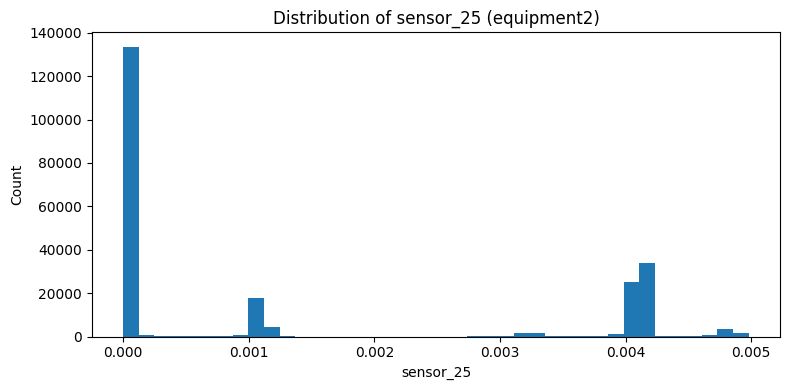

In [53]:
# Distribution of one sensor
plt.hist(eq2[example_sensor2].dropna(), bins=40)
plt.xlabel(example_sensor2)
plt.ylabel("Count")
plt.title(f"Distribution of {example_sensor2} (equipment2)")
plt.tight_layout()
plt.show()

The values are heavily concentrated around zero, indicating a zero-dominant sensor. A few clusters of higher values represent different operation modes across recipe steps. Preprocessing such as normalization or log-scaling may be required due to the heavy skew.

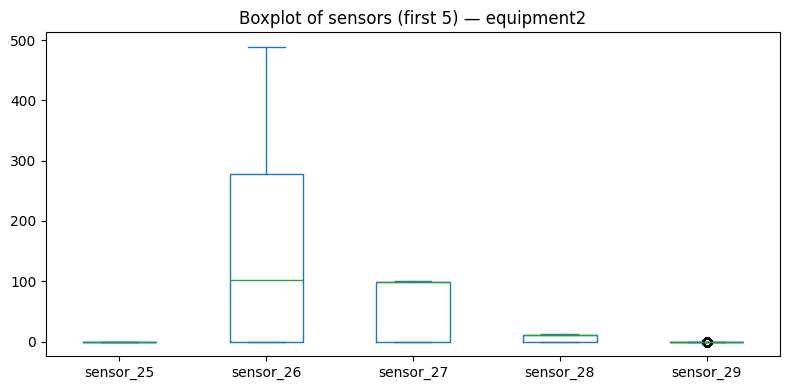

In [54]:
eq2[sensor_cols_eq2[:5]].plot(kind="box")
plt.title("Boxplot of sensors (first 5) — equipment2")
plt.tight_layout()
plt.show()

1. sensor_26 has a very large dynamic range (up to ~500), much larger than the others.
2. sensor_29 shows an extremely narrow range and is mostly zero, acting like a binary/discrete sensor.
3. sensor_25 is again shown to be zero-heavy.
4. sensor_27 and sensor_28 have more continuous distributions.

Overall, Equipment2 has highly inconsistent sensor scales, making normalization absolutely necessary.

In [55]:
# Constant sensors
sensor_variances_eq2 = eq2[sensor_cols_eq2].var()
sensor_variances_sorted_eq2 = sensor_variances_eq2.sort_values()

print("Smallest variances (equipment2):")
print(sensor_variances_sorted_eq2.head(10))

near_constant_threshold = 1e-3
near_constant_sensors_eq2 = sensor_variances_sorted_eq2[
    sensor_variances_sorted_eq2 < near_constant_threshold
]

print("\nSensors with variance < threshold (possible near-constant, equipment2):")
print(near_constant_sensors_eq2)

Smallest variances (equipment2):
sensor_25     0.000003
sensor_34     0.000004
sensor_29     0.000014
sensor_33     0.000202
sensor_36     0.000207
sensor_56     0.238517
sensor_55     0.418145
sensor_44     0.803091
sensor_41    18.220984
sensor_28    30.531153
dtype: float64

Sensors with variance < threshold (possible near-constant, equipment2):
sensor_25    0.000003
sensor_34    0.000004
sensor_29    0.000014
sensor_33    0.000202
sensor_36    0.000207
dtype: float64


Sensors such as sensor_25, sensor_34, sensor_29, sensor_33, and sensor_36 show almost zero variance. These sensors barely change over time and may contribute very little to prediction. -> They could be removed or transformed into binary indicators instead of continuous features.

Compared to Equipment1, Equipment2 contains more near-constant sensors, indicating sensor-level sparsity.

In [56]:
# Number of unique values per sensor
sensor_unique_counts_eq2 = eq2[sensor_cols_eq2].nunique().sort_values()

print("\nSensors with the fewest unique values (equipment2):")
print(sensor_unique_counts_eq2.head(10))


Sensors with the fewest unique values (equipment2):
sensor_33      2
sensor_29      2
sensor_36      2
sensor_27      3
sensor_44      3
sensor_28      5
sensor_30      8
sensor_43     78
sensor_42    111
sensor_56    174
dtype: int64


These operate more like digital or categorical sensors rather than continuous analog signals.

Such sensors should not be scaled like normal continuous variables — binary encoding or direct use is more appropriate.

Sensors with the highest zero ratio (equipment2):
sensor_33    0.999798
sensor_36    0.999793
sensor_29    0.829985
sensor_48    0.650312
sensor_46    0.641520
sensor_30    0.581859
sensor_25    0.573881
sensor_31    0.478681
sensor_32    0.413950
sensor_50    0.398718
dtype: float64


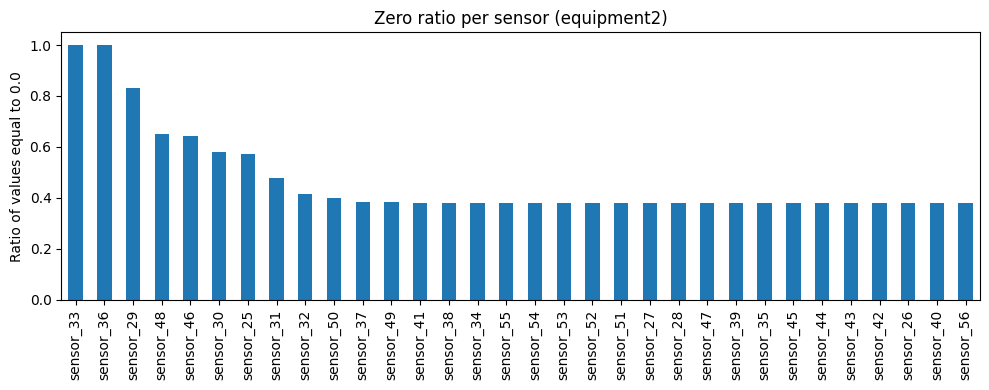

In [57]:
# Zero-heavy sensors -> potential dead sensors
# Ratio of zeros in each sensor
zero_ratio_eq2 = (eq2[sensor_cols_eq2] == 0).mean().sort_values(ascending=False)

print("Sensors with the highest zero ratio (equipment2):")
print(zero_ratio_eq2.head(10))

plt.figure(figsize=(10, 4))
zero_ratio_eq2.plot(kind="bar")
plt.title("Zero ratio per sensor (equipment2)")
plt.ylabel("Ratio of values equal to 0.0")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

sensor_33, sensor_36, and sensor_29 have zero-ratios above 0.999. → These sensors are almost always zero.

Many other sensors have zero ratios between 0.4 and 0.9.

This means Equipment2 has far more zero-heavy sensors than Equipment1.

Special handling is necessary: "activation ratio" features, separate normalization for sparse sensors, avoiding aggressive outlier removal

In [58]:
# Duplicate (lot, water, timestamp) check
# Check for duplicated (lot, wafer, timestamp) combinations
dup_mask_eq2 = eq2.duplicated(subset=["lot", "wafer", "timestamp"], keep=False)
num_duplicates_eq2 = dup_mask_eq2.sum()

print("Number of rows with duplicated (lot, wafer, timestamp) in equipment2:", 
      num_duplicates_eq2)

if num_duplicates_eq2 > 0:
    dup_examples_eq2 = eq2[dup_mask_eq2].sort_values(
        ["lot", "wafer", "timestamp"]
    ).head(20)
    display(dup_examples_eq2)
else:
    print("No duplicated (lot, wafer, timestamp) combinations found in equipment2.")

Number of rows with duplicated (lot, wafer, timestamp) in equipment2: 0
No duplicated (lot, wafer, timestamp) combinations found in equipment2.


Outlier counts per sensor (|z| > 3) — equipment2:
sensor_41    3965
sensor_37     433
sensor_36      48
sensor_33      47
sensor_56      13
sensor_49      12
sensor_31      12
sensor_30       0
sensor_44       0
sensor_55       0
dtype: int64

Sensor with most outliers (equipment2): sensor_41


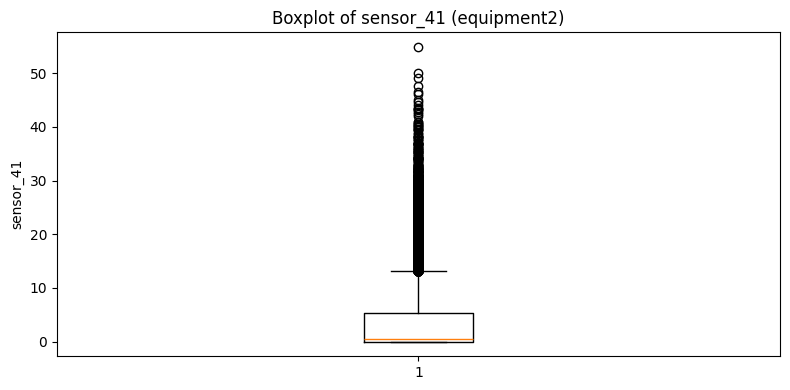

In [59]:
# Simple outlier screening per sensor (z-score)
from scipy import stats

# z-score based outlier count per sensor (|z| > 3)
outlier_counts_eq2 = {}

for col in sensor_cols_eq2:
    vals = eq2[col].dropna()
    if vals.std() == 0:
        outlier_counts_eq2[col] = 0
        continue
    z = np.abs((vals - vals.mean()) / vals.std())
    outlier_counts_eq2[col] = (z > 3).sum()

outlier_counts_eq2 = pd.Series(outlier_counts_eq2).sort_values(ascending=False)

print("Outlier counts per sensor (|z| > 3) — equipment2:")
print(outlier_counts_eq2.head(10))

sensor_most_outliers_eq2 = outlier_counts_eq2.index[0]
print("\nSensor with most outliers (equipment2):", sensor_most_outliers_eq2)

vals2 = eq2[sensor_most_outliers_eq2].dropna()
plt.boxplot(vals2)
plt.title(f"Boxplot of {sensor_most_outliers_eq2} (equipment2)")
plt.ylabel(sensor_most_outliers_eq2)
plt.tight_layout()
plt.show()

sensor_41 produces ~3965 outliers, significantly more than all other sensors. -> This indicates a highly active and high-variance sensor, which may capture important process variation related to wafer quality.

Several other sensors have moderate outlier counts, but many have none.

Outliers in this domain often represent valid physical things going on rather than noise — should not remove them blindly.

### Final Interpretation of Equipment 2 EDA

From the exploratory analysis of Equipment 2, the dataset is clean and complete, with no missing values and a consistent length of 176 timestamps for every wafer. This regular and well-aligned structure means that time-series feature extraction can be performed reliably without dealing with gaps or irregular sequences.

Compared to Equipment 1, the sensors in Equipment 2 show more diverse and uneven behavior. Several sensors stay at zero for most of the process and activate only briefly, indicating that they function more like event or step-based signals. On the other hand, some continuous sensors exhibit wider dynamic ranges and fluctuate throughout the recipe, capturing more detailed process information. There are also a few sensors with very low variance or very few unique states, which suggests that they behave like discrete machine indicators rather than continuous measurements.

Correlation analysis shows a mix of highly redundant sensors and sensors that behvae independently, meaning that some chaannels provide overlapping information while others capture unique aspects of the prcoess. Outlier detection also reveals that certain sensors produce many extreme values, which may represent meaningful process shifts rather than random noise.

Overall, Equipment 2 appears more heterogeneous than Equipment 1, containing a mixture of continuous signals, sparse event-type sensors, and low-variance channels. These characteristics highlight the importance of appying sensor-specific feature engineering before building wafer-level features for machine learning.

### Interpretation for both equipment data

After examining both equipment datasets, I found that they share a similar structure but exhibit very different sensor behaviors. Both machines record data at 176 timestamps per wafer without missing values or duplicates, which givves a clean foundation for reliable feature engineering. However, the sensors across the two machines behave in noticeably different ways because the equipment themselves operate differently.

Equipment 1 tends to have more continuous signals that vary smoothly throughout the process, along with a few sparse sensors that activate only during specific recipe steps. Equipment 2, on the other hand, contains a larger number of zero-heavy and near-constant sensors, suggesting that many of its channels are event-triggered or only measure specific phases. Additionally, several sensors in Equipment 2 have extremely large amplitudes or produce many outliers, which indicates stronger process variability. Overall, this means that sensors across the two machines do not share the same scale, meaning, or activation pattern.

Because of these characteristics, it is not appropriate to treat all sensors as a uniform group. Instead, sensors should be categorized into different types - continuous sensors, sparse or zero-dominatnt sensors, binary-like sensors, and highly correlated sensors. Each type should undergo different feature engineering. For example, zero-heavy sensors may be better represented using acitvation ratios or duration-based features rather than raw values, and nearly constant sensors with very low variance may be removed entirely because they contribute little to prediction. Highly correlated sensors should be handled using feature selection or dimensionality reduction to avoid redundancy.

Although the two machines behave differently, they should not be modeled separately. The final wafer quality is influenced by both pieces of equipment, meaning that the most informative model will combine the features extracted from Equipment 1 and Equipment 2. however, the datasets should not be merged directly at the timestamp level because the sensors are not aligned in meaning or scale. Instead, each equipment's time-series should be independently summarized into wafer-level features (such as mean, variance, max, slopes, and activation metrics). After feature extraction, the two feature sets can be merged using the wafer ID, and then joined witht eh response dataset.

In summary, both datasets are clean and well organized, but their sensors have very different roles. Rather than removing many sensors, the best approach is to group them based on behavior and apply sensor-specific feature engineering. After creating wafer-level features for both machines, these features should be combined to train a single predictive model, since the quality depends on infoormation from both Equipment 1 and Equipment 2.


## Response EDA

In [61]:
resp.head()
resp.info()
resp.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   lot       2638 non-null   object 
 1   wafer     2638 non-null   int64  
 2   response  2638 non-null   float64
 3   class     2638 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 82.6+ KB


,wafer,response
count,2638.000000,2638.000000
mean,13.072782,0.610433
std,7.227440,0.442311
min,1.000000,0.360000
25%,7.000000,0.396000
50%,13.000000,0.417600
75%,19.000000,0.462600
max,25.000000,2.028600


In [75]:
resp['class'].value_counts()
resp['class'].value_counts(normalize=True)

class
good    0.799848
bad     0.200152
Name: proportion, dtype: float64

No missing values

2638 rows

Columns: lot, wafer, response, class

Class counts:
class
good    2110
bad      528
Name: count, dtype: int64
class
good    0.799848
bad     0.200152
Name: proportion, dtype: float64


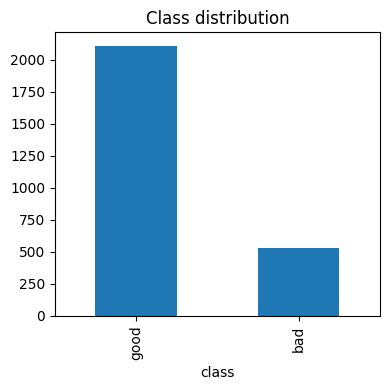

In [76]:
# Class imbalance
print("Class counts:")
print(resp['class'].value_counts())
print(resp['class'].value_counts(normalize=True))

plt.figure(figsize=(4,4))
resp['class'].value_counts().plot(kind='bar')
plt.title("Class distribution")
plt.tight_layout()
plt.show()

Strong class imbalance. Needs class weight, or sampling methods, or performance metrics like F1, AUC instead of accuracy.

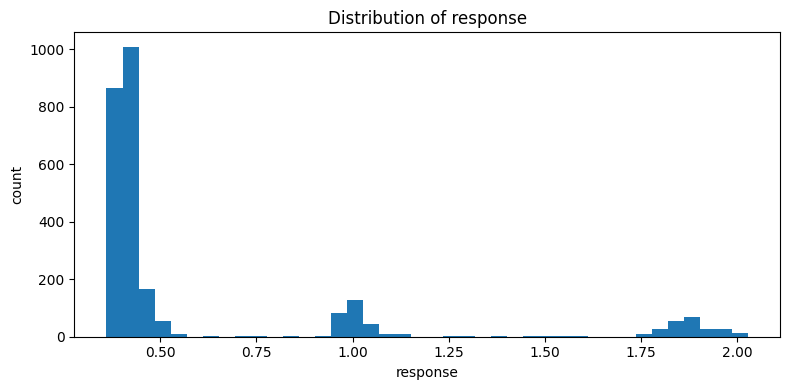

In [77]:
# Response distribution
plt.hist(resp['response'], bins=40)
plt.title("Distribution of response")
plt.xlabel("response")
plt.ylabel("count")
plt.tight_layout()
plt.show()

Clear multi-modal distribution -> 3 clusters

Response is not normal, not continuous smooth value -> This confirms we may want to model each wafer with extracted features instead of raw regression.

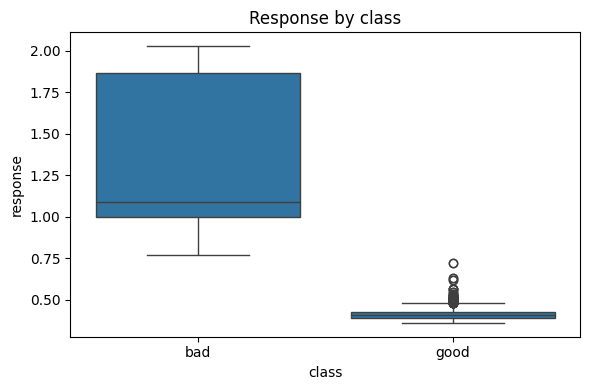

In [79]:
import seaborn as sns

# Relationship between response and class
plt.figure(figsize=(6,4))
sns.boxplot(data=resp, x='class', y='response')
plt.title("Response by class")
plt.tight_layout()
plt.show()

good wafers -> Response tightly clustered around 0.35–0.5
bad wafers -> Response around 1.0-2.0 -> higher variance

Response almost perfectly separates good/bad -> response is a continuous quality metric, class is basically thresholded response

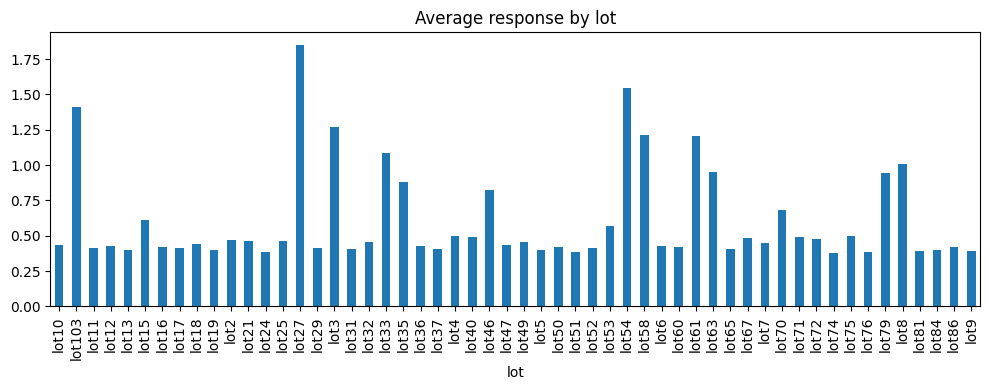

In [80]:
# Lot-level distribution
plt.figure(figsize=(10,4))
resp.groupby('lot')['response'].mean().plot(kind='bar')
plt.title("Average response by lot")
plt.tight_layout()
plt.show()

Most lots have low average response values around 0.35–0.50, which aligns with the "good" class range.

Several lots (e.g., lot29, lot54, lot61, lot103) exhibit significantly higher average responses (up to ~1.8–2.0), indicating systematic quality degradation in those lots.

Lot identity is likely a meaningful feature. Certain lots consistently produce poor wafers, implying upstream process issues.

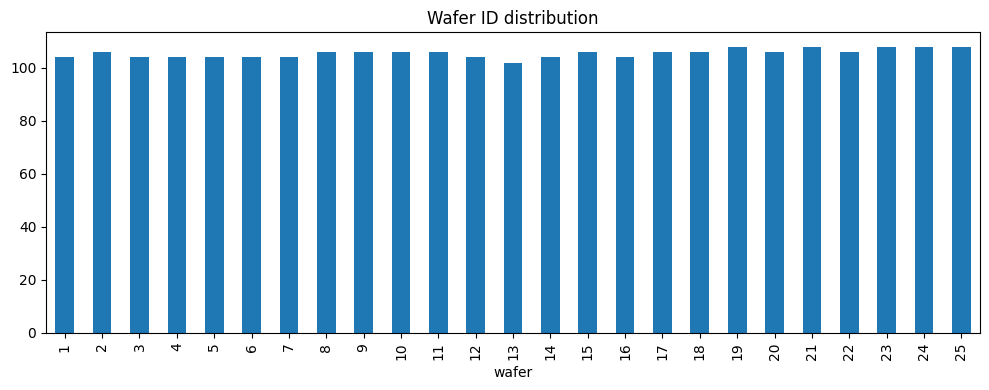

In [81]:
# Wafer distribution
plt.figure(figsize=(10,4))
resp['wafer'].value_counts().sort_index().plot(kind='bar')
plt.title("Wafer ID distribution")
plt.tight_layout()
plt.show()

All wafer IDs appear uniformly and evenly across the dataset. No wafer ID shows unusually high or low counts.

Wafer ID is not correlated with quality or response. It acts only as a positional identifier and is unlikely to provide predictive value. It may eventually be dropped during modeling.

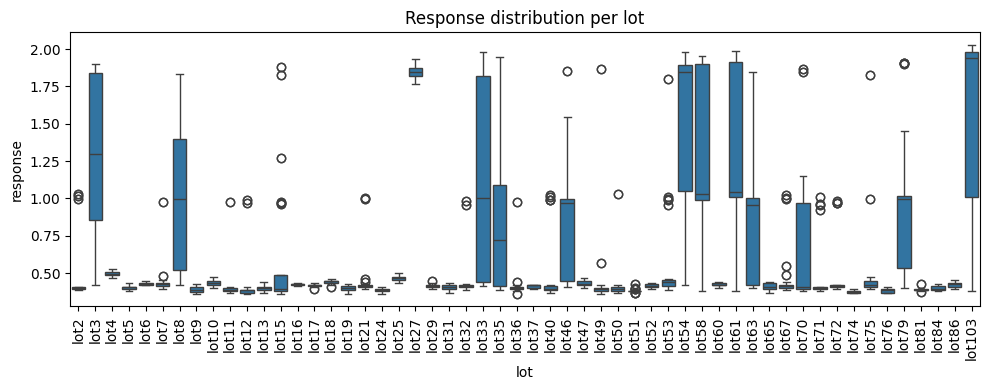

In [82]:
# Response distribution by lot
plt.figure(figsize=(10,4))
sns.boxplot(data=resp, x='lot', y='response')
plt.title("Response distribution per lot")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Many lots have tightly clustered response values around 0.4 (mostly “good” wafers).

Certain lots show very wide distributions, including many extreme values (e.g., lots 29, 54, 61, 103).

The lots with high variation or high median response are the same lots that appear problematic in the earlier bar plot.

The distribution strongly suggests that quality problems often occur at the lot level. Some lots produce both good and bad wafers, while others produce almost exclusively bad ones. -> This supports the idea of systemic process variations rather than random noise.

In [83]:
# Response outliers
z = np.abs((resp['response'] - resp['response'].mean()) / resp['response'].std())
outliers = resp[z > 3]
print("Outliers (response > 3 std):")
print(outliers)

Outliers (response > 3 std):
         lot  wafer  response class
596    lot33      2    1.9800   bad
635    lot35     20    1.9458   bad
871    lot54      2    1.9386   bad
872    lot54      3    1.9800   bad
916    lot58     22    1.9530   bad
918    lot58     24    1.9476   bad
945    lot61      1    1.9692   bad
946    lot61      2    1.9386   bad
952    lot61      8    1.9710   bad
954    lot61     10    1.9512   bad
959    lot61     15    1.9872   bad
1296  lot103      3    2.0286   bad
1297  lot103      4    1.9710   bad
1298  lot103      5    1.9908   bad
1299  lot103      6    1.9782   bad
1300  lot103      7    2.0142   bad
1301  lot103      8    1.9422   bad
1302  lot103      9    1.9728   bad
1304  lot103     11    2.0088   bad
1306  lot103     13    1.9980   bad
1308  lot103     15    1.9890   bad
1310  lot103     17    1.9566   bad
1314  lot103     21    1.9746   bad
1316  lot103     23    1.9656   bad
1915   lot33      2    1.9800   bad
1954   lot35     20    1.9458   bad

All extreme outliers have response values around 1.9–2.0. Every single outlier is labeled “bad.” Outliers cluster heavily in specific lots (mainly lot54, lot61, lot103).

These are not noise or measurement errors. They represent true severe-quality failures, and removing them would erase the most important failure cases. Outliers are meaningful signals and must be retained.

### Final interpretation for response EDA

The response provides clean wafer-level labels - each row corresonds to one wafer with its lot ID, wafer ID, a continuous quality score (response), and a binary class(good/bad). There are no missing values or duplicate wafers, so this table can be merged directly with the wafer-level features that will be extracted from Equipment 1 and Equipment 2.

EDA shows a strong class imbalance - most wafers are labeled good and only a small portion are bad. The continuous response values are clearly separated by class - good wafers have low response values (around 0.35-0.5), while bad wafers have much higher values (around 1.0-2.0). This means that the class label is essentially a theresholded version of the response score, and both represent the same underlying quality scale. For modeling, I can treat this either as a regression problem on response or as a classification problem on class, but I will need to use metrics and techniques that handle imbalance.

At the lot leve, some lots consistently show much higher average response and larger variance, indicating systematic process problems in specific batches (lots with many bad wafers and extreme outliers). In contrast wafer ID itself appears to be just a positional identifier and does not show any meaningful pattern. The extreme high-response values are all associated with bad wafers and problematic lots, so they should be kept as important failure cases rather than removed as noise. Overall, response.csv provvides a strong and well-structured target signal, with the main challenges coming from class imbalance and lot-level quality variation.